# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import time
import pickle
from datetime import datetime
from tqdm.auto import tqdm

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as MSE

import fftoptionlib as fft
import QuantLib as ql

In [121]:
%load_ext autoreload
%autoreload 2
from models import SABR, Heston, Variance_Gamma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MSFT data

In [85]:
msft_calls = pd.read_pickle("data/msft_calls.pickle")
msft_puts = pd.read_pickle("data/msft_puts.pickle")
expirations = pd.read_pickle("data/expirations.pickle")

msft_stock_price = 294.3900146484375
evaluation_date = '2022-03-16'
maturities = np.array([
    (datetime.strptime(expiration, '%Y-%m-%d') - 
    (datetime.strptime(evaluation_date, '%Y-%m-%d') if evaluation_date else datetime.today())).days / 256 
    for expiration in expirations
])

ql.Settings.instance().evaluationDate = ql.Date(16, 3, 2022)

In [86]:
maturities

array([0.0078125 , 0.03515625, 0.0625    , 0.08984375, 0.11328125,
       0.14453125, 0.171875  , 0.25390625, 0.36328125, 0.47265625,
       0.609375  , 0.71875   , 0.85546875, 1.2109375 , 1.4296875 ,
       1.78515625, 2.6328125 ])

# Support functions

In [5]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [6]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

In [7]:
def plot_opt_prices(
    strikes, 
    opt_prices, 
    expirations,
    stock_price=msft_stock_price, 
    title=''
):
    if opt_prices.shape[0] == len(expirations):
        opt_prices = opt_prices.T
        
    plt.figure(figsize=(8,5))
    plt.title(title)
    for i, e in enumerate(expirations):
        plt.plot(strikes, opt_prices[:,i], marker='.', label=e)
    plt.axvline(stock_price, c='red', linestyle='--', label='Stock price')
    plt.legend(title='Expiration date', framealpha=0.5)
    plt.xlabel('Stike, $')
    plt.ylabel('Option price, $')
    plt.show()

# Data preparation for build surfaces

Intersect available strikes between different expirations to get a complete grid for the implied volatility surface

## Put options

In [87]:
df_lens = np.array([len(df) for df in msft_puts])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_puts = [msft_puts[i] for i in indxs]
expirations = [expirations[i] for i in indxs]
maturities = maturities[indxs]

strikes = msft_puts[0].strike
for row in msft_puts:
  strikes = np.intersect1d(strikes, row.strike)

opt_prices = np.array([(df.bid + df.ask)[df.strike.isin(strikes)] / 2 for df in msft_puts])
opt_prices[np.isnan(opt_prices)] = 3.5e-2

vols = np.array([df.impliedVolatility.loc[df.strike.isin(strikes)] for df in msft_puts])

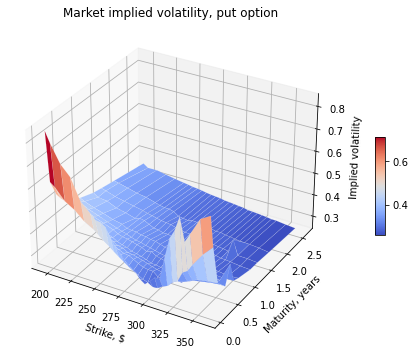

In [93]:
plot_surface(strikes, maturities, vols, title='Market implied volatility, put option');

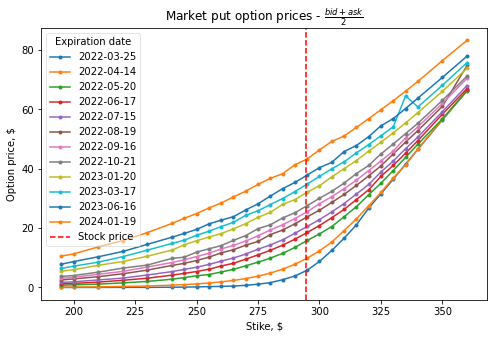

In [94]:
plot_opt_prices(strikes, opt_prices, np.array(expirations), title=r'Market put option prices - $\frac{bid + ask}{2}$')

# Models

## SABR

In [95]:
%%time
sabr = SABR(msft_stock_price)

sabr_times = []
for i, t, in enumerate(tqdm(maturities)):
    start = time.time()
    sabr.fit(strikes, vols[i,:], t)
    end = time.time()
    sabr_times.append(end-start)

100%|██████████| 12/12 [00:00<00:00, 61.88it/s]

CPU times: user 179 ms, sys: 16.1 ms, total: 195 ms
Wall time: 197 ms


In [96]:
print(f'SABR calibration time {np.sum(sabr_times):0.5f} sec.')

SABR calibration time 0.19310 sec.


In [97]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
sabr_surface = sabr.iv_surface(strikes_net, maturities)

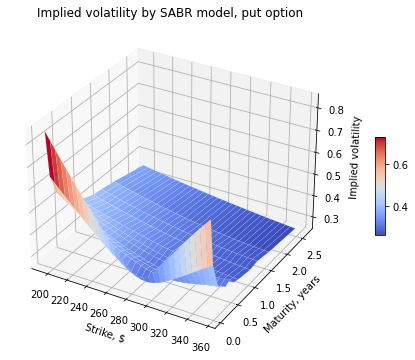

In [98]:
plot_surface(strikes_net, maturities, sabr_surface, 'Implied volatility by SABR model, put option')

### Train MSE

In [99]:
%%timeit
sabr_train_vols = sabr.iv_surface(strikes, maturities)

598 µs ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
sabr_train_vols = sabr.iv_surface(strikes, maturities)

In [101]:
MSE(vols, sabr_train_vols)

0.00021115327322548667

### All MSE

In [102]:
sabr.MSE_all(msft_puts, maturities)

0.011349736776175842

### Option prices

In [103]:
sabr_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, sabr_train_vols, 'put')
MSE(opt_prices, sabr_opt_prices)

16.872342734450772

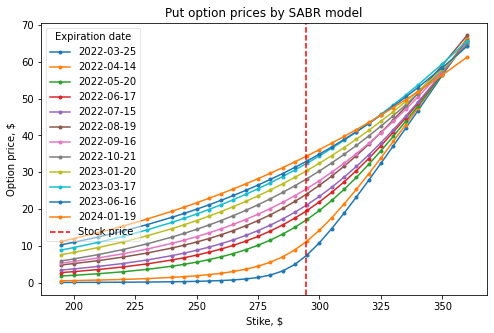

In [104]:
plot_opt_prices(strikes, sabr_opt_prices, expirations, title='Put option prices by SABR model')

## Heston

In [105]:
%%time
heston = Heston(msft_stock_price)
heston.fit(strikes, vols, expirations, method='L-BFGS-B')

CPU times: user 13.4 s, sys: 70.1 ms, total: 13.5 s
Wall time: 13.6 s


In [106]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
heston_surface = heston.iv_surface(strikes_net, maturities)

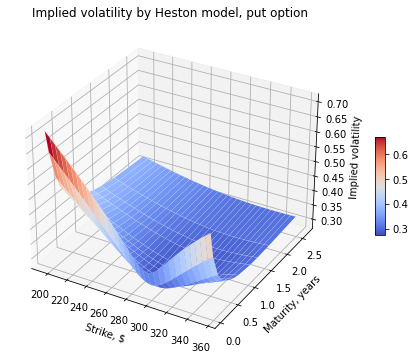

In [107]:
plot_surface(strikes_net, maturities, heston_surface, 'Implied volatility by Heston model, put option')

### Train MSE

In [108]:
%%time
heston_train_vols = heston.iv_surface(strikes, maturities)

CPU times: user 29.9 ms, sys: 314 µs, total: 30.2 ms
Wall time: 30.4 ms


In [109]:
MSE(vols, heston_train_vols)

0.0009754732305499385

### All MSE

In [110]:
heston.MSE_all(msft_puts, maturities)

0.01447539049125415

### Option prices

In [111]:
heston_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)

for i,t in enumerate(tqdm(expirations)):
    exercise = ql.EuropeanExercise(ql.Date(t, '%Y-%m-%d'))
    for j,K in enumerate(strikes):
        payoff = ql.PlainVanillaPayoff(ql.Option.Put, K)
        option = ql.EuropeanOption(payoff, exercise)
        option.setPricingEngine(heston.engine)
        heston_opt_prices[i,j] = option.NPV()

MSE(opt_prices, heston_opt_prices)

100%|██████████| 12/12 [00:00<00:00, 351.72it/s]


20.62209961089271

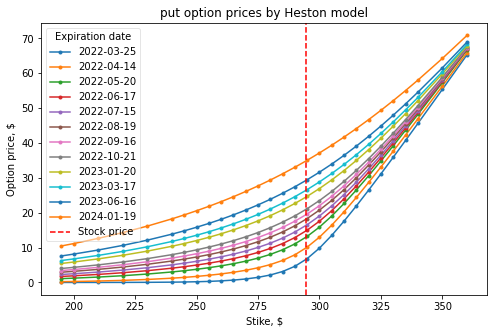

In [112]:
plot_opt_prices(strikes, heston_opt_prices, expirations, title='put option prices by Heston model')

## Variance-Gamma

In [143]:
vg = Variance_Gamma(msft_stock_price, option_type='put')

vg.fit(expirations[11], strikes, vols[11], frac_itm=0.6, frac_ootm=0.4)


In [147]:
%%time
vg = Variance_Gamma(msft_stock_price, option_type='put')

vg_times = []
for i, expir in enumerate(tqdm(expirations)):
    start = time.time()
    vg.fit(expirations[i], strikes, vols[i], frac_ootm=0.6 if i!=11 else 0.4)
    end = time.time()
    vg_times.append(end-start)

100%|██████████| 12/12 [00:16<00:00,  1.35s/it]

CPU times: user 15.3 s, sys: 307 ms, total: 15.7 s
Wall time: 16.2 s


In [148]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
vg_surface = vg.iv_surface(strikes_net, expirations)

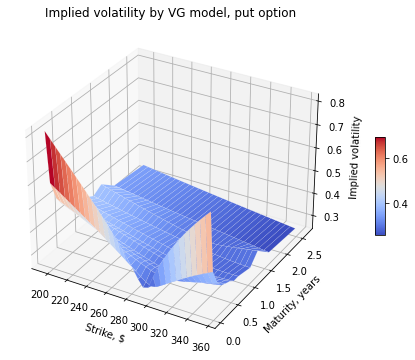

In [149]:
plot_surface(strikes_net, maturities, vg_surface, 'Implied volatility by VG model, put option')

### Train MSE

In [150]:
%%time
vg_train_vols = vg.iv_surface(strikes, expirations)

CPU times: user 139 ms, sys: 7.4 ms, total: 146 ms
Wall time: 209 ms


In [151]:
MSE(vols, vg_train_vols)

0.0002785303747163067

### All MSE

In [152]:
vg.MSE_all(msft_puts, expirations)

0.012902603654742509

### Option prices


In [153]:
vg_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)
for i, exp in enumerate(tqdm(expirations)):
    option_obj = vg.get_option_obj(exp)
    vg_opt_prices[i] = vg.get_vg_prices(*vg.params[i], option_obj, strikes)

MSE(opt_prices, vg_opt_prices)

100%|██████████| 12/12 [00:00<00:00, 95.63it/s]


26.13016304209763

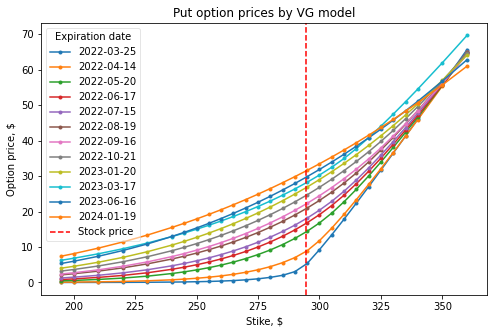

In [154]:
plot_opt_prices(strikes, vg_opt_prices, expirations, title='Put option prices by VG model')

# Near and far MSE

In [155]:
mask1 = maturities <= 1
mask2 = maturities > 1

for mod in ['sabr', 'heston', 'vg']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_opt_prices'][mask2]))

sabr
Near 3.158141349966076
Far 44.30074550342015
heston
Near 7.4985091178746615
Far 46.86928059692881
vg
Near 4.90785187471946
Far 68.57478537685398


# Upload neural network results

In [156]:
with open('data/results/nn_a_put_surface.pkl', 'rb') as f:
    nn_a_put_surface = pickle.load(f)

with open('data/results/nn_b_put_surface.pkl', 'rb') as f:
    nn_b_put_surface = pickle.load(f)

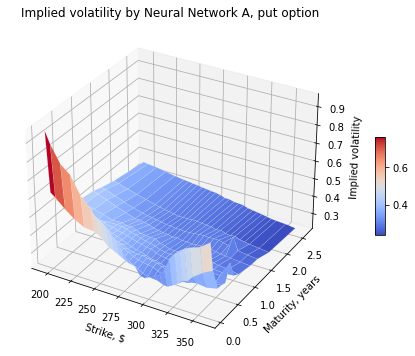

In [157]:
plot_surface(strikes, maturities, nn_a_put_surface, title='Implied volatility by Neural Network A, put option')

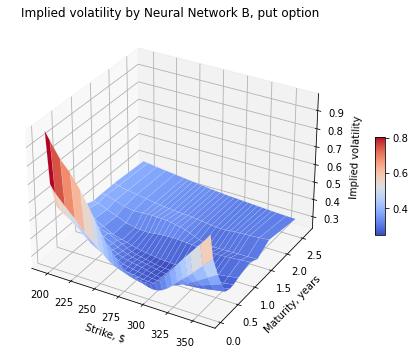

In [158]:
plot_surface(strikes, maturities, nn_b_put_surface, title='Implied volatility by Neural Network B, put option')

In [159]:
nn_a_put_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, nn_a_put_surface, 'put')
nn_b_put_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, nn_b_put_surface, 'put')

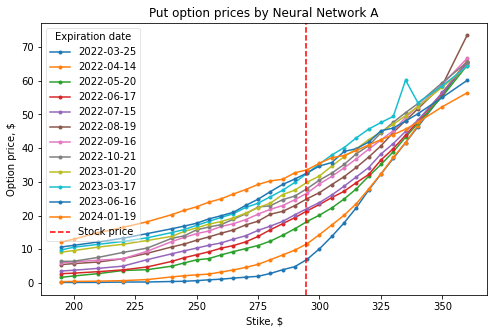

In [160]:
plot_opt_prices(strikes, nn_a_put_opt_prices, expirations, title='Put option prices by Neural Network A')

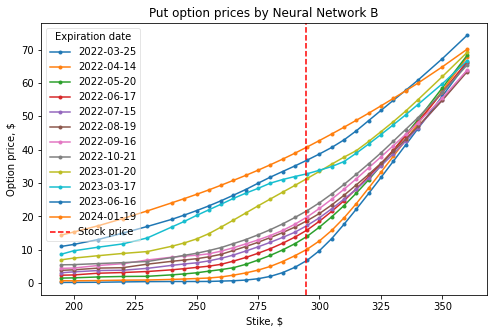

In [161]:
plot_opt_prices(strikes, nn_b_put_opt_prices, expirations, title='Put option prices by Neural Network B')

In [162]:
for mod in ['nn_a', 'nn_b']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_put_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_put_opt_prices'][mask2]))

nn_a
Near 4.332185021155319
Far 57.25586073352531
nn_b
Near 8.954691619419219
Far 16.191811882443336


# Comparison all models

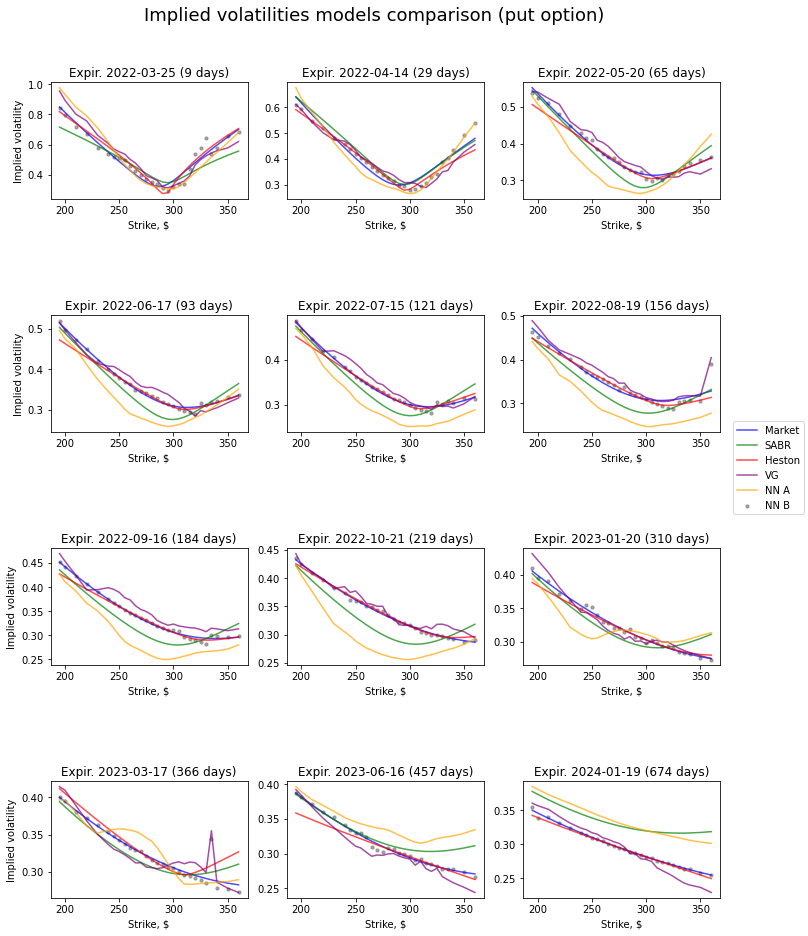

In [166]:
all_ivs = [
    vols,
    sabr_train_vols,
    heston_train_vols,
    vg_train_vols,
    nn_a_put_surface,
    nn_b_put_surface
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Implied volatilities models comparison (put option)", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    ax.scatter(strikes, all_ivs[0][i], c=colors[0], label=labels[0], alpha=0.7, s=10)
    for j in range(len(all_ivs)-1):
        ax.plot(strikes, all_ivs[j+1][i], c=colors[j+1], label=labels[j+1], alpha=0.7)
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Implied volatility')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()

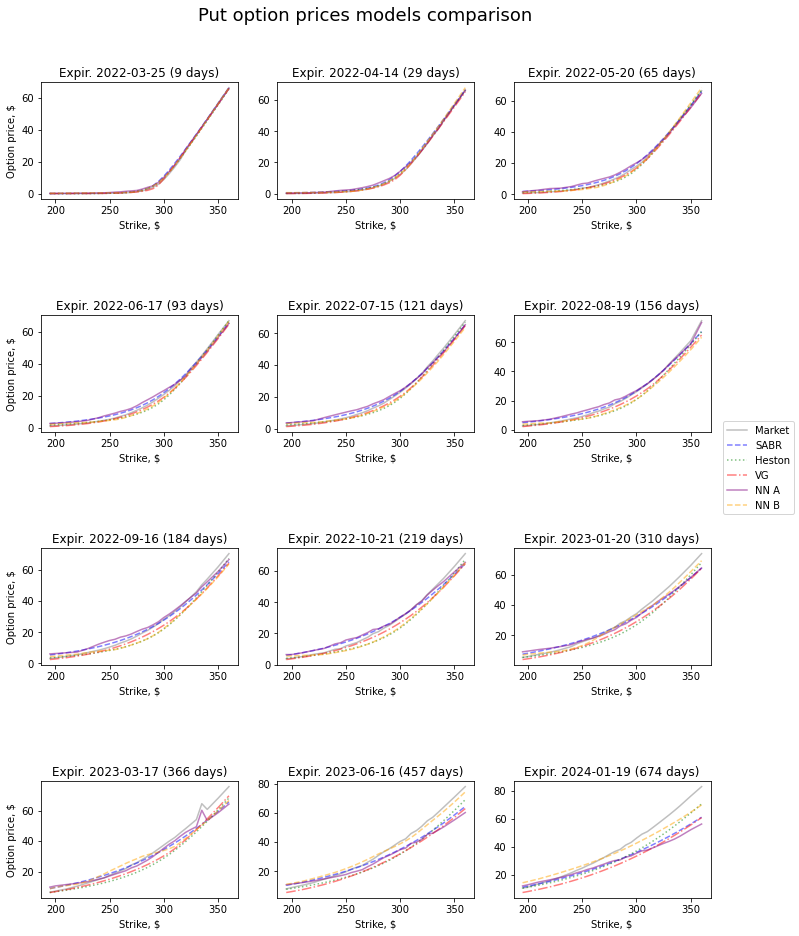

In [167]:
all_prices = [
    opt_prices,
    sabr_opt_prices,
    heston_opt_prices,
    vg_opt_prices,
    nn_a_put_opt_prices,
    nn_b_put_opt_prices,
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Put option prices models comparison", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    for j in range(len(all_prices)):
        ax.plot(strikes, all_prices[j][i], c=colors[j], label=labels[j], alpha=0.5, linestyle=linestyles[j % 4])
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Option price, $')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()